# AutoAI Scoring, Training or Deployment

## Set up

### Install these libraries and versions

In [1]:
pip install ibm-watson-machine-learning==1.0.91

In [31]:
pip install scikit-learn==0.23.2

In [32]:
pip install xgboost==1.3.3

In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from ibm_watson_machine_learning.helpers.connections import DataConnection,CP4DAssetLocation,AssetLocation
from ibm_watson_machine_learning.experiment import AutoAI
import project_lib
project = project_lib.Project()
tqdm.pandas()
%matplotlib inline

In [3]:
token = os.environ['USER_ACCESS_TOKEN']

In [4]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
        "token": token,
        "instance_id" : "openshift",
        "url": os.environ['RUNTIME_ENV_APSX_URL'],
        "version": "3.5",
        "username": "mluser1",
        "password": "mluser1"
    
     }

client = APIClient(wml_credentials)

In [5]:
client.set.default_project(os.environ['PROJECT_ID'])

'SUCCESS'

## Retrieve data

In [6]:
df = pd.read_csv(project.get_file('regression_leakage_autoAI.csv'))

In [7]:
df.columns

Index(['Base Claims Cost', 'Leakage %', 'Handler Case Load at Allocation',
       'Notification Delay', 'Claim Complexity', 'Claim Type',
       'Days from Policy Inception to Date of Claim', 'Claim Handler Level',
       'Number of Previous Claims', 'Claim Handler Minus Complexity'],
      dtype='object')

In [8]:
x_test = df.drop(columns=['Leakage %']).iloc[:100].dropna()
y_test = df['Leakage %'].iloc[:100]

In [9]:
for file_dic in project.get_assets():
    if file_dic['name']=='regression_leakage_autoAI.csv':
            asset_id = file_dic['asset_id']

In [10]:
details_sample = client.data_assets.get_details(asset_id)
details_sample

{'metadata': {'project_id': '5ef4c7dc-1d05-46a9-bbcc-1404d4166777',
  'guid': 'f224bda9-3179-41bc-94d2-25ddff4552ea',
  'href': '/v2/assets/f224bda9-3179-41bc-94d2-25ddff4552ea?project_id=5ef4c7dc-1d05-46a9-bbcc-1404d4166777',
  'asset_type': 'data_asset',
  'created_at': '2021-04-20T07:37:49Z',
  'last_updated_at': '2021-04-20T07:37:49Z',
  'attachment_id': 'c724e39b-bc6c-45d0-9062-ace0db77a037'},
 'entity': {'data_asset': {'mime_type': 'text/csv', 'dataset': False}}}

## AutoAI

### Existing model (from earlier UI step)

In [11]:
from ibm_watson_machine_learning.experiment import AutoAI
experiment = AutoAI(wml_credentials, project_id=os.environ['PROJECT_ID'])

In [12]:
training_data_connection = DataConnection(location=AssetLocation(details_sample['metadata']['guid']))

In [13]:
experiment.runs.list()

timestamp                                run_id      state  \
0   2021-05-19T16:57:05.089Z  17e9926b-e461-4d8e-a810-479a8a91f7c4  completed   
6   2021-05-19T16:44:56.649Z  6e700db7-5cc7-4e35-a4e1-e0918dc3efce   canceled   
8   2021-05-19T15:02:42.758Z  a52653d4-9ecc-45cd-ad97-7ce28fd25deb  completed   
5   2021-05-19T14:45:42.546Z  5572bee7-de01-4476-b43e-adabb1247a48  completed   
3   2021-05-19T14:28:51.989Z  26d31ef8-c70d-4d46-9068-1420c6a34ecd  completed   
10  2021-05-19T13:58:48.997Z  ec1b2a7d-92b0-4d61-bf9c-22b66a966598  completed   
7   2021-05-19T13:42:22.105Z  949b99ab-d651-4d90-8348-d1f4a1ceff95  completed   
4   2021-05-19T12:49:13.495Z  3b29b2db-0ed2-4802-acb1-b43559b297a4  completed   
9   2021-05-19T11:50:48.551Z  e1b36bc9-ecab-434e-83e4-8ec5883eaaa1  completed   
2   2021-04-20T08:05:52.595Z  1c1700fd-a456-4dfa-9795-90499b2b67ff  completed   
1   2021-04-20T07:42:03.989Z  1b060dd3-ace8-4e07-8937-dc346b6cb4e3  completed   

   auto_pipeline_optimizer name  
0            Leakage_Prediction  
6          Leakage_Prediction_2  
8     Claims Leakage Prediction  
5          Leakage_Prediction_2  
3     Claims Leakage Prediction  
10    Claims Leakage Prediction  
7     Claims Leakage Prediction  
4     Claims Leakage Prediction  
9     Claims Leakage Prediction  
2     Claims Leakage Prediction  
1            Leakage_Prediction

#### Note: Insert latest run_id from the table ouput above corresponding to the AutoAI experiment name you created from the UI (e.g. Leakage_Prediction)

In [14]:
optim = experiment.runs.get_optimizer('insert_latest_run_id')
optim.summary()

Enhancements                           Estimator  \
Pipeline Name                                                    
Pipeline_4         HPO, FE               XGBRegressorEstimator   
Pipeline_2             HPO               XGBRegressorEstimator   
Pipeline_3         HPO, FE               XGBRegressorEstimator   
Pipeline_7         HPO, FE  GradientBoostingRegressorEstimator   
Pipeline_8         HPO, FE  GradientBoostingRegressorEstimator   
Pipeline_1                               XGBRegressorEstimator   
Pipeline_6             HPO  GradientBoostingRegressorEstimator   
Pipeline_5                  GradientBoostingRegressorEstimator   

               holdout_explained_variance  training_mean_squared_log_error  \
Pipeline Name                                                                
Pipeline_4                       0.732065                         0.000822   
Pipeline_2                       0.749359                         0.000838   
Pipeline_3                       0.749359                         0.000838   
Pipeline_7                       0.769075                         0.000849   
Pipeline_8                       0.769075                         0.000849   
Pipeline_1                       0.748815                         0.000872   
Pipeline_6                       0.750278                         0.000873   
Pipeline_5                       0.746194                         0.000905   

               holdout_median_absolute_error  \
Pipeline Name                                  
Pipeline_4                          0.023935   
Pipeline_2                          0.020293   
Pipeline_3                          0.020293   
Pipeline_7                          0.020015   
Pipeline_8                          0.020015   
Pipeline_1                          0.024561   
Pipeline_6                          0.023261   
Pipeline_5                          0.025719   

               holdout_root_mean_squared_log_error  \
Pipeline Name                                        
Pipeline_4                                0.033163   
Pipeline_2                                0.031929   
Pipeline_3                                0.031929   
Pipeline_7                                0.030750   
Pipeline_8                                0.030750   
Pipeline_1                                0.032390   
Pipeline_6                                0.031895   
Pipeline_5                                0.032513   

               holdout_mean_squared_error  training_explained_variance  \
Pipeline Name                                                            
Pipeline_4                       0.001599                     0.795206   
Pipeline_2                       0.001487                     0.791909   
Pipeline_3                       0.001487                     0.791909   
Pipeline_7                       0.001369                     0.790897   
Pipeline_8                       0.001369                     0.790897   
Pipeline_1                       0.001493                     0.784962   
Pipeline_6                       0.001479                     0.782889   
Pipeline_5                       0.001513                     0.776785   

               training_r2  training_median_absolute_error  \
Pipeline Name                                                
Pipeline_4        0.794240                        0.023140   
Pipeline_2        0.790184                        0.022296   
Pipeline_3        0.790184                        0.022296   
Pipeline_7        0.787798                        0.022704   
Pipeline_8        0.787798                        0.022704   
Pipeline_1        0.782625                        0.022344   
Pipeline_6        0.780682                        0.021818   
Pipeline_5        0.774032                        0.023176   

               training_mean_squared_error  \
Pipeline Name                                
Pipeline_4                        0.001189   
Pipeline_2                        0.001216   
Pipe

In [15]:
best_pipeline_info = optim.summary().sort_values('holdout_mean_squared_error').iloc[0]

In [16]:
best_pipeline_info.name

'Pipeline_7'

In [17]:
pipeline_name = best_pipeline_info.name

In [18]:
best_pipeline = optim.get_pipeline(pipeline_name=pipeline_name)

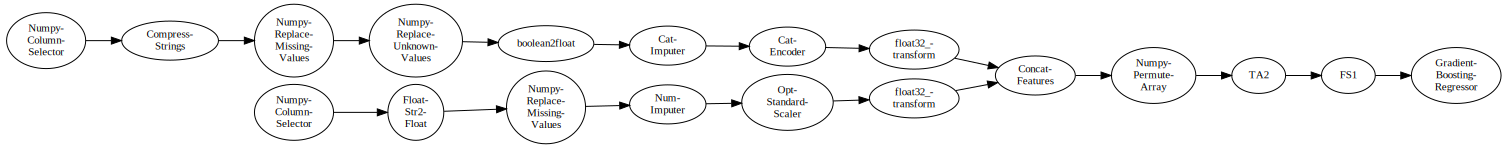

In [19]:
best_pipeline.visualize()

In [20]:
best_pipeline.predict(x_test.values)

array([0.126121  , 0.13308581, 0.12498768, 0.11938031, 0.11686625,
       0.12369426, 0.11363256, 0.120839  , 0.12117612, 0.12694679,
       0.11891841, 0.12877495, 0.11922459, 0.12882675, 0.11063459,
       0.12308806, 0.11631638, 0.14189885, 0.11875132, 0.12417187,
       0.12432342, 0.11674174, 0.12103905, 0.11544051, 0.13558371,
       0.12317596, 0.12308259, 0.12100456, 0.12456288, 0.12006023,
       0.13463108, 0.12003514, 0.12170414, 0.116572  , 0.12708565,
       0.12222171, 0.12181896, 0.12645745, 0.1168805 , 0.12221481,
       0.11751945, 0.11710753, 0.12869332, 0.12166125, 0.12670064,
       0.12777419, 0.1339818 , 0.12946695, 0.11896402, 0.12514393,
       0.13750978, 0.12038086, 0.12881316, 0.13338947, 0.12666009,
       0.14263681, 0.12287304, 0.13563643, 0.12007122, 0.12373762,
       0.13438904, 0.10775273, 0.11947083, 0.13417617, 0.1218064 ,
       0.14325898, 0.1265253 , 0.14824105, 0.10863094, 0.12890674,
       0.12491471, 0.1188439 , 0.13004182, 0.1211261 , 0.14074

### Train new AutoAI model (alternative method)

In [21]:
auto_pipelines = experiment.optimizer(
            name='Claims Leakage Prediction',
            desc='AutoAI for the Claims Leakage Accelerator',
            prediction_type=AutoAI.PredictionType.REGRESSION,
            prediction_column='Leakage %',
            scoring=AutoAI.Metrics.MEAN_SQUARED_ERROR)

In [22]:
auto_pipelines_details = auto_pipelines.fit(
        training_data_reference=[training_data_connection],
        background_mode=False)

Training job 791c2ac1-df8a-4a0c-bdb9-12d13848a032 completed: 100%|████████| [09:12<00:00,  5.53s/it]


In [23]:
auto_pipelines.get_run_details()

{'metadata': {'created_at': '2021-05-19T17:02:03.285Z',
  'description': 'Claims Leakage Prediction - wml pipeline: 6392f838-705d-4de5-868c-32dc7e439fbc',
  'guid': '791c2ac1-df8a-4a0c-bdb9-12d13848a032',
  'id': '791c2ac1-df8a-4a0c-bdb9-12d13848a032',
  'modified_at': '2021-05-19T17:11:16.488Z',
  'name': 'AutoAI for the Claims Leakage Accelerator - wml pipeline: 6392f838-705d-4de5-868c-32dc7e439fbc',
  'project_id': '5ef4c7dc-1d05-46a9-bbcc-1404d4166777',
  'tags': ['autoai']},
 'entity': {'description': 'Claims Leakage Prediction - wml pipeline: 6392f838-705d-4de5-868c-32dc7e439fbc',
  'name': 'AutoAI for the Claims Leakage Accelerator - wml pipeline: 6392f838-705d-4de5-868c-32dc7e439fbc',
  'pipeline': {'id': '6392f838-705d-4de5-868c-32dc7e439fbc'},
  'project_id': '5ef4c7dc-1d05-46a9-bbcc-1404d4166777',
  'results_reference': {'location': {'training': '/projects/5ef4c7dc-1d05-46a9-bbcc-1404d4166777/assets/auto_ml/auto_ml.7daed870-b641-4327-aaea-acb59c854275/wml_data/791c2ac1-df8a-

In [24]:
auto_pipelines.predict(x_test)

array([0.12768191, 0.13013107, 0.12016369, 0.12022246, 0.10619787,
       0.13875999, 0.12106491, 0.11791665, 0.12778892, 0.1292677 ,
       0.15258317, 0.13361572, 0.11832871, 0.13544206, 0.097574  ,
       0.11568017, 0.11916097, 0.15098962, 0.12847917, 0.1117635 ,
       0.12280761, 0.1252822 , 0.10974167, 0.09984376, 0.13471784,
       0.11079688, 0.13352507, 0.12010093, 0.14025326, 0.13388874,
       0.15890975, 0.13464491, 0.13259618, 0.11456579, 0.12850334,
       0.12123313, 0.13124749, 0.11528865, 0.1067034 , 0.13435718,
       0.12408297, 0.12674953, 0.12532224, 0.10618206, 0.12819639,
       0.13174172, 0.14041056, 0.13455747, 0.1347525 , 0.12565206,
       0.14227784, 0.1130214 , 0.13047175, 0.1444225 , 0.12541166,
       0.1546478 , 0.11584198, 0.15692069, 0.1339328 , 0.13434677,
       0.12292773, 0.10437654, 0.12271846, 0.12627637, 0.09440188,
       0.13683297, 0.14543359, 0.14970233, 0.12269729, 0.13801877,
       0.11753602, 0.11405909, 0.11445211, 0.12222461, 0.12148

## Deploy existing AutoAI model

In [25]:
exp_data = optim.get_run_details()['metadata']

In [26]:
# Specify a name for the target deployment space
SPACE_NAME = 'ClaimsLeakage'

# Check is the space already exists
space_uid = ''
for space in client.spaces.get_details()['resources']:
    if space['entity']['name'] == SPACE_NAME:
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        break

if space_uid == '':
    print("Deployment space",SPACE_NAME,"not found.")

Unsetting the project_id ...


In [27]:
target_space_id = space_uid

from ibm_watson_machine_learning.deployment import WebService
service = WebService(source_wml_credentials=wml_credentials,
                     target_wml_credentials=wml_credentials,
                     source_project_id=os.environ['PROJECT_ID'],
                     target_space_id=target_space_id)

deployment_details=service.create(
model=pipeline_name,
experiment_run_id= exp_data['guid'],
deployment_name=f'{pipeline_name}_webservice'
)

Preparing an AutoAI Deployment...
Published model uid: f79306e0-29dd-47d6-8847-1b7723910ee5
Deploying model f79306e0-29dd-47d6-8847-1b7723910ee5 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: 'f79306e0-29dd-47d6-8847-1b7723910ee5' started

#######################################################################################


initializing....
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='93f0766c-26d8-455c-aecc-0a7431c168ac'
------------------------------------------------------------------------------------------------




In [28]:
client.deployments.list()

------------------------------------  ------------------------  -----  ------------------------
GUID                                  NAME                      STATE  CREATED
93f0766c-26d8-455c-aecc-0a7431c168ac  Pipeline_7_webservice     ready  2021-05-19T17:36:25.111Z
5e240e7f-ea41-44a2-a7b0-fba934966e4f  Pipeline_7_webservice     ready  2021-05-19T15:05:28.092Z
3bede666-ae56-4e16-bf92-c720573e0ee2  claims_leakage_Shiny_App  ready  2021-04-28T17:44:53.441Z
9d5a2d3d-3a99-413d-9e7f-3a76956c9187  claims leakage DO model   ready  2021-04-28T16:40:39.752Z
28b8d326-c5da-4145-9279-49955f5904b2  claims leakage DO model   ready  2021-04-28T16:31:19.045Z
3c6a2dcd-9ec2-4918-ad75-4978d23ffd47  claims leakage DO model   ready  2021-04-28T16:19:39.313Z
ffc683b8-04dd-4e5e-b1c7-e7e3156dc48a  claims leakage DO model   ready  2021-04-28T09:23:40.108Z
57966280-43d8-4303-894b-2f1bd099250e  Pipeline_7_webservice     ready  2021-04-20T08:27:28.044Z
------------------------------------  -------------------

In [29]:
payload = {"input_data":[{
                    "fields": x_test.columns.tolist(),
                    "values": x_test.values.tolist()
            }]}

#### Note: Insert GUID of Pipeline_7_webservice from the client.deployments.list() table 

In [30]:
%%time
results = client.deployments.score('insert_GUID',payload)
results

CPU times: user 5.1 ms, sys: 2.56 ms, total: 7.66 ms
Wall time: 676 ms


{'predictions': [{'fields': ['prediction'],
   'values': [[0.12612099522628503],
    [0.1330858078359835],
    [0.12498768176239992],
    [0.11938031196355779],
    [0.11686624888469098],
    [0.12369425662472446],
    [0.11363255916767136],
    [0.1208390027973994],
    [0.12117612171837161],
    [0.12694678623160607],
    [0.11891840879893084],
    [0.12877495102224826],
    [0.11922458904733882],
    [0.1288267470574582],
    [0.1106345899749454],
    [0.12308806188018961],
    [0.11631638013503329],
    [0.14189885061603513],
    [0.11875131730908314],
    [0.12417186822120523],
    [0.12432342029612485],
    [0.11674173835459525],
    [0.12103904716536314],
    [0.11544050569902822],
    [0.13558371071789205],
    [0.123175964425345],
    [0.12308258654170491],
    [0.12100455517774661],
    [0.124562875729833],
    [0.12006022818573553],
    [0.13463108143203475],
    [0.1200351406715975],
    [0.12170413519225794],
    [0.11657200095241038],
    [0.12708564560661278],
    [0.122